**STEG - Tunisian Company of Electricity and Gas Fraud detection**
* Societe Tunisienne del'Electricite at du Gaz (STEG) is the leading electricity and gas provider in Tunisia.
* STEG has almost 5 million customers (4mill electricity and 1mill gas consumers) and provides over 15k GW/H annually. 
* STEG suffered tremendous losses in the order of 200 million Tunisian Dinars (~70 million USD) due to fraudulent manipulations of meters by consumers.\
**Objective:**\
While all of STEG’s clients are metered, electricity theft has been a growing challenge since the Revolution, reflecting a deterioration of the social contract. This project focuses on predicting the fraudulent customers.\
* Link to dataset in kaggle: https://www.kaggle.com/mrmorj/fraud-detection-in-electricity-and-gas-consumption


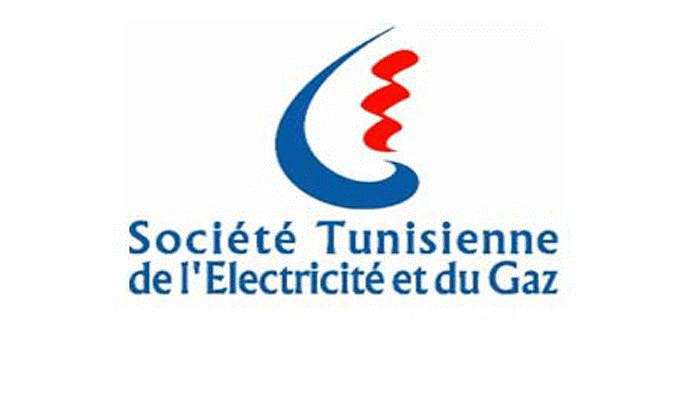

In [1]:
from IPython.display import Image, display;
display(Image(filename='STEG.gif',width=600, height=300, embed=True))

In [2]:
import pandas as pd
import matplotlib as plt
import seaborn as sns
import numpy as np
import seaborn as sns
import plotly.express as px
import cufflinks as cf
cf.go_offline()
import plotly.io as pio

# Import Data

In [3]:
df_invoice = pd.read_csv('invoice_train.csv', low_memory=False, infer_datetime_format=True, parse_dates=[1])
df_customer = pd.read_csv('client_train.csv')

In [4]:
df = df_invoice.merge(df_customer,on='client_id',how='left').sort_values(by=['client_id','counter_number','old_index','new_index']).reset_index().drop('index', axis=1)

In [43]:
# backup of original combined datafrmae
# df_backup = df.copy()
# df = df_backup
# pd.set_option("display.max_rows", 101)

In [9]:
df.drop(columns=['creation_date','reading_remarque','client_catg','counter_statue','counter_coefficient','counter_statue'],inplace=True)

# EDA and visualizations

* The following chart shows higher rate of fraudulent clients in districts: 62, 63, 69. This led us to calculate a ratio of fraudulent clients as a number representing a client.

In [ ]:
x = pd.crosstab(df.disrict, df.target ,normalize='columns')
x.plot.bar(figsize=(10,5), title='District vs. target (normalized by target)');


* The following pie chart shows that some regions have a higher rate of potential fraudulent clients. This led us to calculate a ratio of fraudulent clients as a number representing the region of a client.

In [ ]:
fig, ax = plt.subplots(facecolor='white')
x = pd.crosstab(df.region, df.target)[1].sort_values(ascending=False)
explode = (0.1, 0.1, 0.1, 0.1, 0.1, 0,0,0,0,0,0,0,0,0,0,0,0,0, 0,0,0,0,0,0,0)
x.plot.pie(figsize=(11,8), title='Fraudulent clients distribution by region', autopct='%1.1f%%', explode=explode, shadow=True);

* The following chart reveals a clear separation between gas and electric counters tariff types. We decided to calculate a ratio of fraudulent clients as a number representing a client tariff.

In [ ]:
x = pd.crosstab(df.tarif_type, df.counter_type)
x.plot.bar(figsize=(10,5), title='Counter type (ELEC, GAZ) by tariff type');

In [10]:
# add new column 'avg_monthly_consum'
df['avg_month_consum']=np.log1p(df.loc[:,['consommation_level_1','consommation_level_2', 'consommation_level_3', 'consommation_level_4']].sum(axis=1)+1)/(df['months_number']+1)

* The following histogram is based on an engineered feature of average monthly consumption. We noticed two areas where the ratio of fraud clients consumption is higher than normal clients.

In [ ]:
fig = px.histogram(df[df.avg_month_consum>0.3], x='avg_month_consum', color='target', barmode='overlay',histnorm='percent',
                    title='Average monthly consumptions ratio for fraudulent and regular clients').show()

# Feature engineering

* Distinguish between clients having one meter or two meters and calculating a ratio between fraud and non fraud clients

In [11]:
sub_df_1 = df.groupby('client_id').filter(lambda x: x['counter_type'].nunique()==1)
sub_df_2 = df.groupby('client_id').filter(lambda x: x['counter_type'].nunique()==2)

gaz_counter_fraud_ratio = (sub_df_1[(sub_df_1.counter_type=='GAZ') & (sub_df_1.target==1)].client_id.nunique()) / (sub_df_1[(sub_df_1.counter_type=='GAZ')].client_id.nunique())
elec_counter_fraud_ratio = (sub_df_1[(sub_df_1.counter_type=='ELEC') & (sub_df_1.target==1)].client_id.nunique()) / (sub_df_1[(sub_df_1.counter_type=='ELEC')].client_id.nunique())
elec_gaz_counters_fraud_ratio = (sub_df_2[sub_df_2.target==1].client_id.nunique()) / (sub_df_2.client_id.nunique())

In [12]:
# add new column 'tarif_ratio' calculating the ratio fraud clients out of non fraud clients per tariff type 
def func(x):
    if ((x['counter_type'].nunique()==1) and (x['counter_type'].values.all()=='ELEC')):
        return elec_counter_fraud_ratio
    elif ((x['counter_type'].nunique()==1) and (x['counter_type'].values.all()=='GAZ')):
        return gaz_counter_fraud_ratio
    else:
        return elec_gaz_counters_fraud_ratio

ratio_3 = df.groupby('client_id').apply(func).to_dict()
df['tarif_ratio'] = df['client_id'].map(ratio_3)

In [13]:
# add new column 'district_ratio' calculating the ratio of fraud clients out of non fraud clients per district
ratio_1 = df.groupby('disrict').apply(lambda x: (x['target']==1).sum() / (x['target']==0).sum().astype(float)).to_dict()
df['district_ratio'] = df['disrict'].map(ratio_1)

In [14]:
# add new column 'region_ratio' calculating the ratio of fraud clients out of non fraud clients per region
ratio_2 = df.groupby('region').apply(lambda x: (x['target']==1).sum() / (x['target']==0).sum().astype(float)).to_dict()
df['region_ratio'] = df['region'].map(ratio_2)

In [15]:
# dataframe with added 'tarif_ratio','district_ratio','region_ratio' columns
# df_backup_2 = df.copy()
# df = df_backup_2

In [16]:
# Add new column 'consum_percent' to help segregate possible fraud clients
df['consum_percent'] = ((df.avg_month_consum > 1.4) | ((df.avg_month_consum > 0.85) & (df.avg_month_consum < 1.105))).astype(int)

* Based on the previous calculation of average consumption ratio, we now calculate the probability for fraud per client. 

In [17]:
# new dataframe with 'common_consum' calculation
def divided_consum(df_sub):
    return ((df_sub['consum_percent']==1).sum()+1) / ((df_sub['consum_percent']==0).sum()+1)

common_consum = df.groupby(['client_id']).apply(divided_consum).to_frame('common_consum')

In [18]:
# Add column based on the diagonal diff between 'old_index' and 'new_index' columns to identify inconsistency of counter readings
def get_diff(df):
    diffs = (df['old_index'].shift(-1) - df['new_index'])
    return diffs

aaa = df.groupby(['client_id','counter_type'], as_index=False).apply(get_diff)
df['index_diff'] = aaa.droplevel(0)
df['index_diff'].fillna(0, inplace=True)

df.loc[((df['index_diff']>1000) | (df['index_diff']<-1000)),'index_diff'] = 0 # remove "noise" values from 'index_diff'

* The average reading of counter diffs divided by total consumption per client.

In [19]:
# Add new column 'avg_diff'
def divided_diff_by_consum(df_sub):
    return df_sub['index_diff'].abs().sum() / float(df_sub[['consommation_level_1','consommation_level_2','consommation_level_3','consommation_level_4']].sum().sum()+1)

avg_diff = df.groupby(['client_id','counter_type']).apply(divided_diff_by_consum).unstack(fill_value=0).rename({'ELEC':'avg_diff_ELEC','GAZ':'avg_diff_GAZ'}, axis=1)

In [20]:
# dataframe with added columns: 'avg_diff','consum_percent','index_diff'
# df_backup_3 = df.copy()
# df = df_backup_3

* The average number of times a counter was replaced for a client.

In [21]:
# Add new column 'avg_counter_change'
def counter_changed(df_sub):
    return df_sub['counter_number'].nunique() / float(df_sub['months_number'].sum()+1)

avg_counter_change = df.groupby(['client_id','counter_type']).apply(counter_changed).unstack(fill_value=0).rename({'ELEC':'counter_ELEC_changed','GAZ':'counter_GAZ_changed'}, axis=1)

In [22]:
# merge new columns into main df
df = df.merge(((common_consum > 0.8).astype(int)), how='left', on='client_id')
df = df.merge(avg_diff, how='left', on='client_id')
df = df.merge(avg_counter_change, how='left', on='client_id')

In [23]:
# dataframe with added columns: 'avg_counter_change' and merging other columns
# df_backup_4 = df.copy()
# df = df_backup_4

* Features grouping for dimensionality reduction.

In [24]:
df['counter_code_bins'] = pd.cut(df.counter_code, bins=[0, 65, 1e6], include_lowest=True, labels=['counter_code_GAZ', 'counter_code_ELEC'])

In [25]:
df.drop(columns=['counter_number', 'old_index', 'new_index', 'months_number', 'invoice_date', 'tarif_type',
                 'counter_code', 'counter_type','consommation_level_1', 'consommation_level_2', 
                 'consommation_level_3', 'consommation_level_4', 'index_diff','avg_month_consum','consum_percent','disrict','region'], inplace=True);

In [26]:
# final dataframe without extra fields
# df_backup_5 = df.copy()
# df = df_backup_5

* Creating final dataset for the model in "wide form" format.

In [27]:
clean_df = df.groupby('client_id')[['target','common_consum','avg_diff_ELEC','avg_diff_GAZ','counter_ELEC_changed','counter_GAZ_changed'
                                ,'counter_code_bins','district_ratio','region_ratio','tarif_ratio']].first()

# Classification modeling

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from statistics import mean
import warnings
warnings.filterwarnings("ignore")

In [30]:
# spliting dataset to X,y and train/test sets
X = clean_df.drop(columns=['target'])
y = clean_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Testing PCA for dimensionality reduction

In [ ]:
ohe = OrdinalEncoder()

column_transform = make_column_transformer((ohe, ['counter_code_bins']), remainder='passthrough')
X_pca = column_transform.fit_transform(X)

pca_transformer = PCA(n_components=9)
df_pca_transformer = pca_transformer.fit(X_pca)
df_pca = df_pca_transformer.transform(X_pca)

# number of components
n_pcs= df_pca_transformer.components_.shape[0]

# get the index of the most important feature on EACH component i.e. largest absolute value
# using LIST COMPREHENSION HERE
most_important = [np.abs(df_pca_transformer.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X.columns

# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# using LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i+1): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_pca_test = pd.DataFrame(sorted(dic.items()))

In [ ]:
df_pca_transformer.explained_variance_ratio_.cumsum()

In [ ]:
df_pca_test

In [ ]:
# New dataframe with only 2 pca components
df_cleaned_2 = pd.DataFrame(data= df_pca[:,0:2], columns=['PC1','PC2'])

X = df_cleaned_2
y = clean_df.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

* After running the PCA modified dataset with XGB model, it turned out that the AUC score was worse than original dataset. So we concluded that PCA is not suitable for our dataset.

## Classification models(LR, DTR, RF) with Cross_validation and Grid search

In [31]:
ohe = OrdinalEncoder()

column_transform = make_column_transformer((ohe, ['counter_code_bins']), remainder='passthrough')

# lr = LogisticRegression(n_jobs=-1, class_weight='balanced',random_state=None)       
# dtr = DecisionTreeClassifier(class_weight='balanced', random_state=42)
rf = RandomForestClassifier(n_estimators=100, class_weight={0:1, 1:9}, random_state=1, max_depth=6, min_samples_leaf=0.01)                                            

pipe_rf = make_pipeline(column_transform, rf) # set the name of the model to run 
# cv = StratifiedKFold(n_splits=5)

# scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc')
# print(scores, mean(scores))

# grid = GridSearchCV(pipe, param_grid= params, cv=5, n_jobs=-1)
# grid.fit(X_train, y_train);
# pipe.fit(X_train, y_train);

In [32]:
# find class weight balance for model class weight parameter
from collections import Counter
counter = Counter(y)
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 16.908


## XGBClassifier

In [ ]:
# params settings for grid search depending on model
params ={}
params['xgbclassifier__min_samples_leaf'] = [0.01]
params['xgbclassifier__max_depth'] = [5,6]
params['xgbclassifier__n_estimators']= [100]
params['xgbclassifier__min_child_weight'] = [2,3,4,5]
params['xgbclassifier__learning_rate'] = [0.1,0.01,0.05]


In [ ]:
xgb = XGBClassifier(objective='binary:logistic' ,scale_pos_weight=9, max_depth=6, n_estimators=100, learning_rate=0.1, min_child_weight = 4, seed=42)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# pipe_xgb = make_pipeline(column_transform, xgb)

# grid = GridSearchCV(pipe, param_grid= params, cv=cv, n_jobs=-1, scoring='roc_auc')
# grid.fit(X_train, y_train);

# evaluate model
scores = cross_val_score(xgb, X_train, y_train, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.4f' % mean(scores))

## LGBMClassifier

In [ ]:
params ={}
# params['lgbmclassifier__min_child_weight'] = [1,3,6]
# params['lgbmclassifier__max_depth'] = [5,6,7]
# params['lgbmclassifier__n_estimators']= [100,200]
# params['lgbmclassifier__learning_rate'] = [0.05, 0.1,0.16]
# params['lgbmclassifier__scale_pos_weight'] = [3,4,5,6]

In [35]:
lgbm = LGBMClassifier(scale_pos_weight=8, max_depth=5, n_estimators=200, learning_rate=0.1, min_child_weight = 6)

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
pipe_lgbm = make_pipeline(column_transform, lgbm)

# grid = GridSearchCV(pipe, param_grid=params, cv=cv, n_jobs=-1, verbose=10, scoring='roc_auc')
# grid.fit(X_train, y_train)

# evaluate model
scores = cross_val_score(lgbm, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
# summarize performance
print('Mean ROC AUC: %.4f' % mean(scores))

Mean ROC AUC: 0.7880


In [36]:
pipe_lgbm.fit(X_train, y_train);

## Voting model

In [ ]:
classifiers = [('rf', pipe_rf), ('xgb', pipe_xgb), ('lgbm', pipe_lgbm)]

clf_voting = VotingClassifier(estimators=classifiers, voting='soft')
clf_voting.fit(X_train, y_train)
# evaluate model
roc_auc_score(y_test, clf_voting.predict_proba(X_test)[:,1])

* Voting resulted with slightly lower AUC score compared to using a single LGBM model.

## Scoring & metrics evaluation

### Feature importance

In [37]:
important_features = pd.Series(data=lgbm.feature_importances_,index=X.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

counter_GAZ_changed     1563
counter_code_bins        850
avg_diff_GAZ             844
counter_ELEC_changed     672
region_ratio             622
district_ratio           235
avg_diff_ELEC            107
common_consum             77
tarif_ratio               17
dtype: int32


### AUC model score

In [38]:
# ROC AUC score on test data
roc_auc_score(y_test, pipe_lgbm.predict_proba(X_test)[:,1])

0.7942162866971874

### Threshold parameter

In [39]:
# threshold tunning
threshold = 0.161
predicted_proba = pipe_lgbm.predict_proba(X_test)
predicted = (predicted_proba[:,1] >= threshold).astype('int')
confusion_matrix(y_test, predicted)

array([[10932, 14654],
       [  141,  1372]], dtype=int64)

### Confusion matrix report

In [40]:
# creating combined confusion matrix and report view
def report(pipe, X, y):
    acc = accuracy_score(y_true=y, 
                         y_pred=predicted)
    cm = pd.DataFrame(confusion_matrix(y_true=y, 
                                       y_pred=predicted), 
                      index=pipe.classes_, 
                      columns=pipe.classes_)
    rep = classification_report(y_true=y, 
                                y_pred=predicted)
    return 'accuracy: {:.3f}\n\n{}\n\n{}'.format(acc, cm, rep)

print(report(pipe_lgbm, X_test, y_test))    

accuracy: 0.454

       0.0    1.0
0.0  10932  14654
1.0    141   1372

              precision    recall  f1-score   support

         0.0       0.99      0.43      0.60     25586
         1.0       0.09      0.91      0.16      1513

    accuracy                           0.45     27099
   macro avg       0.54      0.67      0.38     27099
weighted avg       0.94      0.45      0.57     27099



### f-Beta best parameter

In [41]:
from sklearn.metrics import f1_score, fbeta_score, precision_score, recall_score
# Containers for f-beta, precision, and recall scores at different prob. thresholds
f2_scores = []
f4_scores = []
f5_scores = []
precision_scores = []
recall_scores = []

y_test_probs = pipe_lgbm.predict_proba(X_test)[:,1]

# Define probability thresholds to use, between 0 and 1
probability_thresholds = np.linspace(0, 1, num=100)

# Find scores for each threshold
for p in probability_thresholds:
    
    y_test_preds = []
    
    for prob in y_test_probs:
        if prob > p:
            y_test_preds.append(1)
        else:
            y_test_preds.append(0)
            
    f2 = fbeta_score(y_test, y_test_preds, beta=2)
    f4 = fbeta_score(y_test, y_test_preds, beta=4)
    f5 = fbeta_score(y_test, y_test_preds, beta=5)
    prec = precision_score(y_test, y_test_preds)
    rec = recall_score(y_test, y_test_preds)
        
    f2_scores.append(f2)
    f4_scores.append(f4)
    f5_scores.append(f5)
    precision_scores.append(prec)
    recall_scores.append(rec)

In [42]:
# line chart for finding best beta score and corresponding threshold
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=probability_thresholds, y=f2_scores, mode='lines',name='f2'))
fig.add_trace(go.Scatter(x=probability_thresholds, y=f4_scores, mode='lines',name='f4'))
fig.add_trace(go.Scatter(x=probability_thresholds, y=f5_scores, mode='lines',name='f5'))
fig.add_trace(go.Scatter(x=probability_thresholds, y=precision_scores, mode='lines',name='Precision'))
fig.add_trace(go.Scatter(x=probability_thresholds, y=recall_scores, mode='lines',name='Recall'))
fig.update_layout(xaxis_title="Probability Threshold",
                yaxis_title="f-beta score",
                title="f-beta score vs. probability threshold",
                legend_title="Measures",
                hovermode="x unified")
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)              
fig.show()